## Fracture Skeleton Extraction
#### This notebook contains the steps necessary to extract lines representing fractures taken from an image that clearly shows a map of fractures over an area.

*The specific settings for the grayscale and threshold images may be different depending on the input images. The images being used here are of aerial photos showing fracture sets near the surface outlined as a result of alfalfa plants filling into the water rich fractures.

In [4]:
#import necessary packages
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import cv2
import skimage
%matplotlib inline

#### The first step in this process is to load the desired image and crop it to the appropriate scale

In [5]:
#load images for cropping
im = Image.open(r"C:\Users\csouc\Desktop\Bear Spring Data\Spatial Data\Area_A_Marion_FT.tiff")
width, height = im.size
print(width, height)

#Crop the images using either PIL or openCV
####################
# crop the image to the appropriate scale using PIL
left = 700 #sets the left most bound of the image (counts horizontal pixels from L to R)
top = 300 #sets the upper boundary of the image (counts vertical pixels from top to bottom)
right = 2600 #sets the right most bound of the image
bottom = 2000 #sets the lower bound of the image
imc = im.crop((left, top, right, bottom)) #applies each of the above boundary parameters to the image using crop()
imc.show()  #shows the cropped image in a seprate window #uncomment this code to perform the crop using PIL

#crops the image to the appropriate scale using openCV
image = cv2.imread(r"C:\Users\csouc\Desktop\Bear Spring Data\Spatial Data\Area_A_Marion_FT.tiff")
y=0
x=0
h=2550
w=3300
crop_image = image[x:w, y:h]
#cv2.imshow("Cropped Fracture Imge", crop_image) #uncomment this code to perform crop in openCV
#cv2.waitKey(0) #uncomment this code to perform the crop in openCV

#save the image to the appropriate format
imc.save("Cropped_Fracture.tif") # save PIL Crop
#crop_image.save("Cropped_Fracture.tif") #save openCV crop #uncomment one of these depending on which method of crop you wish to save

3300 2550


#### The second step in this process is to create a grayscale of the image and use that to create a threshold of the image. The thresholding is a process whereby all of the pixels greater than a certain value are assigned one value, else it is assigned a different value. OpenCV includes multiple different processes for thresholding. This threshold image is then applied to the Hough transformation in order to extract lineations from said thresholded image. Therefore it is extremely important that the thresholded image is a good representation of your fracture map.

Grayscale Image


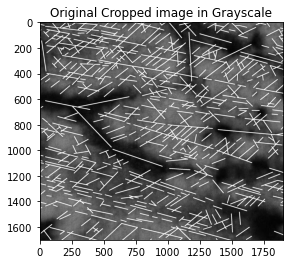

v = 127 is the Threshold value
Simple Threshold Results


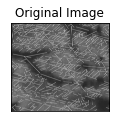

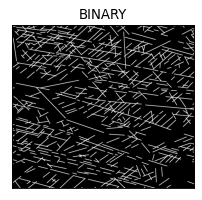

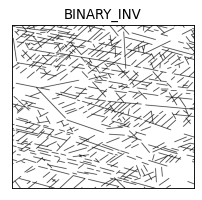

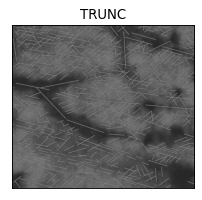

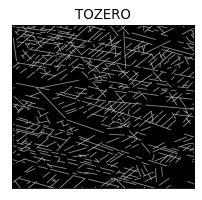

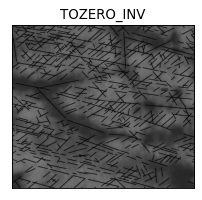

<Figure size 800x800 with 0 Axes>

Adaptive Thresholding


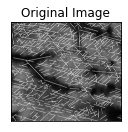

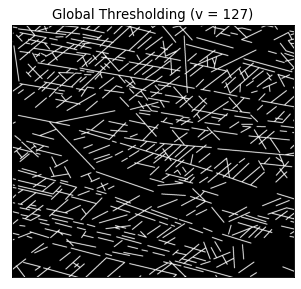

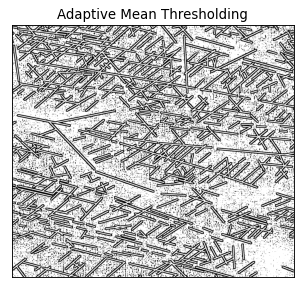

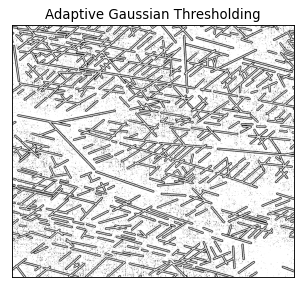

<Figure size 800x800 with 0 Axes>

In [6]:
#Convert image to grayscale
img = cv2.imread('Cropped_Fracture.tif')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print("Grayscale Image")
plt.imshow(img_gray, cmap='gray')
plt.title("Original Cropped image in Grayscale")
plt.show()
#Threshold image (multiple different methods)
###########
v = 127
print(f'v = {v} is the Threshold value')
#"Simple Threshold"
print("Simple Threshold Results")
ret, thresh1 = cv2.threshold(img_gray, v, 255, cv2.THRESH_BINARY)
ret,thresh2 = cv2.threshold(img_gray, v,255,cv2.THRESH_BINARY_INV)
ret,thresh3 = cv2.threshold(img_gray,v,255,cv2.THRESH_TRUNC)
ret,thresh4 = cv2.threshold(img_gray,v,255,cv2.THRESH_TOZERO)
ret,thresh5 = cv2.threshold(img_gray,v,255,cv2.THRESH_TOZERO_INV)

titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
images = [img_gray, thresh1, thresh2, thresh3, thresh4, thresh5]

for i in range(6):
    plt.subplot(2,3,i+1),plt.imshow(images[i],'gray',vmin=0,vmax=255)
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
    plt.figure(figsize=(10,10), dpi=80)
plt.show()


#Adaptive Thresholding Method
print('Adaptive Thresholding')

ret,th1 = cv2.threshold(img_gray,v,255,cv2.THRESH_BINARY)
th2 = cv2.adaptiveThreshold(img_gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11,2)
th3 = cv2.adaptiveThreshold(img_gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)
titles = ['Original Image', 'Global Thresholding (v = 127)',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [img_gray, th1, th2, th3]
for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
    plt.figure(figsize=(10,10), dpi=80)
plt.show()


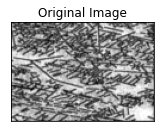

<Figure size 800x800 with 0 Axes>

In [13]:
#resize the fracture csv to match the appropriate size for pyKasso
n= 83
m = 120
import skimage.transform as st
new_th2 = st.resize(th2, (n,m), mode='constant')

images = [new_th2]
#for i in range(len(images)):
plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
plt.title(titles[i])
plt.xticks([]),plt.yticks([])
plt.figure(figsize=(10,10), dpi=80)
plt.show()

np.savetxt('th2_resize', new_th2)


#### The final step in the process is to apply the Hough Transformation to detect the fracture skeleton. This take a binary image as an input, then performs the Hough Transformation and outputs a skeletonized fracture network.

[[ 451  717 1494 1035]
 [ 455  295 1518  483]
 [ 728  798 1496 1033]
 ...
 [1345   18 1372   18]
 [1665  332 1742  280]
 [1417  466 1458  430]]


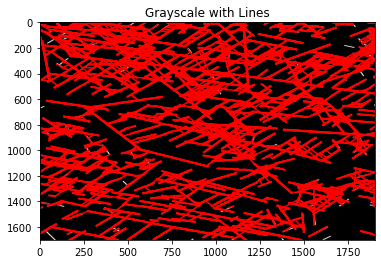

In [8]:
axs = plt.subplots(1)
lines = cv2.HoughLinesP(
    th1, rho=1, theta=np.pi / 180, threshold=128, minLineLength=10, maxLineGap=40,
)
lines = lines.squeeze()
axs[1].set_title("Grayscale with Lines")
axs[1].imshow(th1, aspect="auto", cmap="gray")
for x1, y1, x2, y2 in lines:
    axs[1].plot([x1, x2], [y1, y2], "r")
#cv2.imwrite('linesDetected.jpg', th1)
print(lines)
#np.savetxt('linesexport', lines)
np.savetxt('th2', th2)


In [9]:
import os
os.getcwd()

'C:\\Users\\csouc\\Desktop\\Bear Spring Data\\Bear_Spring_Modeling\\Bear_Spring_pyKasso'